# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables.

In [1]:
import pandas as pd

data = pd.read_csv("DataSet.csv", sep=';', index_col="ind")

print(data)

     EECC TipoEC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  \
ind                                                                          
1    BL09   MAEF        1  32458  146916  220.94       3       127   4.697   
2    BL09   MAEF        2  39967  150917  264.84       3       127   4.697   
3    BL09   MAEF        3  39438  145916  270.29       3       127   4.697   
4    BL09   MAEF        4  30342  145930  207.93       3       127   4.697   
5    BL09   MAEF        5  30361  140921  215.46       3       127   4.697   
..    ...    ...      ...    ...     ...     ...     ...       ...     ...   
142  BL15   MAEF        4  37083  140926  263.14       3       127   4.700   
143  BL21   MAEF        1  39939  142930  279.44       2       146   4.665   
144  BL21   MAEF        2  45292  143926  314.70       2       146   4.665   
145  BL21   MAEF        3  47127  144925  325.20       2       146   4.665   
146  BL21   MAEF        4  39936  142928  279.41       2       1

### Codificación de la categoría TipoEC

In [2]:
data.TipoEC.value_counts()

MAEF    86
STD     32
AEF     20
OFA      8
Name: TipoEC, dtype: int64

In [3]:
dummies = pd.get_dummies(data['TipoEC'])
data = pd.concat([data, dummies], axis = 1)
data = data.drop(columns=['TipoEC'])
print (data)

     EECC  Muestra    Cnn   T(ms)   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU  \
ind                                                                            
1    BL09        1  32458  146916  220.94       3       127   4.697    44082   
2    BL09        2  39967  150917  264.84       3       127   4.697    46265   
3    BL09        3  39438  145916  270.29       3       127   4.697    46517   
4    BL09        4  30342  145930  207.93       3       127   4.697    43374   
5    BL09        5  30361  140921  215.46       3       127   4.697    43788   
..    ...      ...    ...     ...     ...     ...       ...     ...      ...   
142  BL15        4  37083  140926  263.14       3       127   4.700    46187   
143  BL21        1  39939  142930  279.44       2       146   4.665    47227   
144  BL21        2  45292  143926  314.70       2       146   4.665    48747   
145  BL21        3  47127  144925  325.20       2       146   4.665    49176   
146  BL21        4  39936  142928  279.4

### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [4]:
data = data [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
print(data)

     EECC  Muestra  MAEF  OFA  STD   Cnn/s  Ciclos  Enf(mes)  Enr(%)  Mwd/TnU
ind                                                                          
1    BL09        1     1    0    0  220.94       3       127   4.697    44082
2    BL09        2     1    0    0  264.84       3       127   4.697    46265
3    BL09        3     1    0    0  270.29       3       127   4.697    46517
4    BL09        4     1    0    0  207.93       3       127   4.697    43374
5    BL09        5     1    0    0  215.46       3       127   4.697    43788
..    ...      ...   ...  ...  ...     ...     ...       ...     ...      ...
142  BL15        4     1    0    0  263.14       3       127   4.700    46187
143  BL21        1     1    0    0  279.44       2       146   4.665    47227
144  BL21        2     1    0    0  314.70       2       146   4.665    48747
145  BL21        3     1    0    0  325.20       2       146   4.665    49176
146  BL21        4     1    0    0  279.41       2       146   4

### Normalización y discretización de los datos

In [5]:
import numpy as np

tipoMaef = np.array(data.values[:,2], dtype='float')
tipoOfa = np.array(data.values[:,3], dtype='float')
tipoStd = np.array(data.values[:,4], dtype='float')
cuentasSeg = np.array(data.values[:,5], dtype='float')
ciclos = np.array(data.values[:,6], dtype='float')
enfri = np.array(data.values[:,7], dtype='float')
enriq = np.array(data.values[:,8], dtype='float')
QUEMADO = np.array(data.values[:,9], dtype='float')

from scipy import stats
cuentasSegNorm = stats.zscore(cuentasSeg)
ciclosNorm = stats.zscore(ciclos)
enfriNorm = stats.zscore(enfri)
enriqNorm = stats.zscore(enriq)
QUEMADOnorm = stats.zscore(QUEMADO)


from sklearn.preprocessing import KBinsDiscretizer
###################################################################################################
# Elegimos el número de intervalos según las modas en la distribución (ver histogramas más abajo) #
# Sería mejor utilizar 'uniform' o 'quantile' en lugar de usar 'kmeans' ¿?                        #
###################################################################################################
cuentasSegDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Cnn/s']])
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(data[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Enr(%)']])
QUEMADOdis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(data[['Mwd/TnU']])

cuentasSegDis = pd.DataFrame(cuentasSegDis)
enfriDis = pd.DataFrame(enfriDis)
enriqDis = pd.DataFrame(enriqDis)
QUEMADOdis = pd.DataFrame(QUEMADOdis)

### Creo un DataFrame con los arrays normalizados y discretos

In [6]:
data = pd.DataFrame({'EECC': data['EECC'], 'Muestra': data['Muestra'], 'MAEF': tipoMaef, \
                     'OFA': tipoOfa, 'STD': tipoStd, 'Cnn/s': cuentasSegNorm, 'Ciclos': ciclosNorm, \
                     'Enf(mes)': enfriNorm, 'Enr(%)': enriqNorm, 'Mwd/TnU': QUEMADOnorm, \
                     'Cnn/s_D': cuentasSegDis.values[:,0], 'Ciclos_D': ciclos, 'Enf(mes)_D': enfriDis.values[:,0], \
                     'Enr(%)_D': enriqDis.values[:,0], 'Mwd/TnU_D': QUEMADOdis.values[:,0]})

print(data)

     EECC  Muestra  MAEF  OFA  STD     Cnn/s    Ciclos  Enf(mes)    Enr(%)  \
ind                                                                          
1    BL09        1   1.0  0.0  0.0 -0.103873  0.536875 -0.602062  0.871258   
2    BL09        2   1.0  0.0  0.0  0.218885  0.536875 -0.602062  0.871258   
3    BL09        3   1.0  0.0  0.0  0.258954  0.536875 -0.602062  0.871258   
4    BL09        4   1.0  0.0  0.0 -0.199524  0.536875 -0.602062  0.871258   
5    BL09        5   1.0  0.0  0.0 -0.144162  0.536875 -0.602062  0.871258   
..    ...      ...   ...  ...  ...       ...       ...       ...       ...   
142  BL15        4   1.0  0.0  0.0  0.206386  0.536875 -0.602062  0.874454   
143  BL21        1   1.0  0.0  0.0  0.326226 -0.862836 -0.424691  0.837169   
144  BL21        2   1.0  0.0  0.0  0.585461 -0.862836 -0.424691  0.837169   
145  BL21        3   1.0  0.0  0.0  0.662658 -0.862836 -0.424691  0.837169   
146  BL21        4   1.0  0.0  0.0  0.326005 -0.862836 -0.424691

### Cálculo de estadísticos

In [7]:
from scipy.stats import iqr

medias = np.mean(data.values[:,5:10], axis=0)
varianzas = np.var(data.values[:,5:10], axis=0)
medianas = np.median(data.values[:,5:10], axis=0)
intercuartil = iqr(data.values[:,5:10], axis=0)

print ('Medias: ', medias)
print ('Varianzas: ', varianzas)
print ('Medianas: ', medianas)
print ('Distancia intercuartil: ', intercuartil)

Medias:  [2.6234722157238288e-17 1.7793985463170317e-16 -6.691755216918751e-17
 -4.395266494748907e-16 1.5816875967262503e-16]
Varianzas:  [1.0000000000000004 0.9999999999999994 1.0000000000000007
 1.0000000000000018 0.9999999999999998]
Medianas:  [-0.009949516200137608 0.5368754921931596 -0.2473210530770556
 0.6187894885156648 0.2488837009800024]
Distancia intercuartil:  [1.8396259145255103 1.399711104646451 1.857721270967109 1.3475642702806132
 1.5921684196786834]


### Diagramas de cajas e histogramas

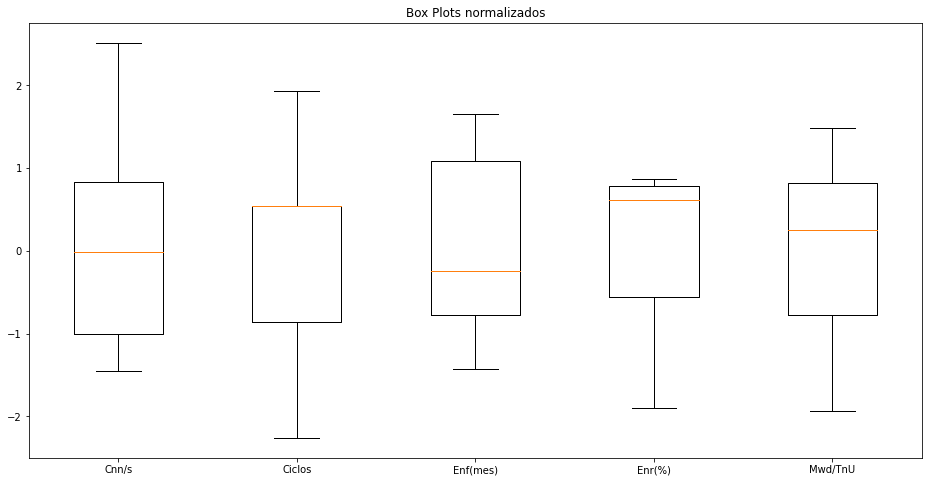

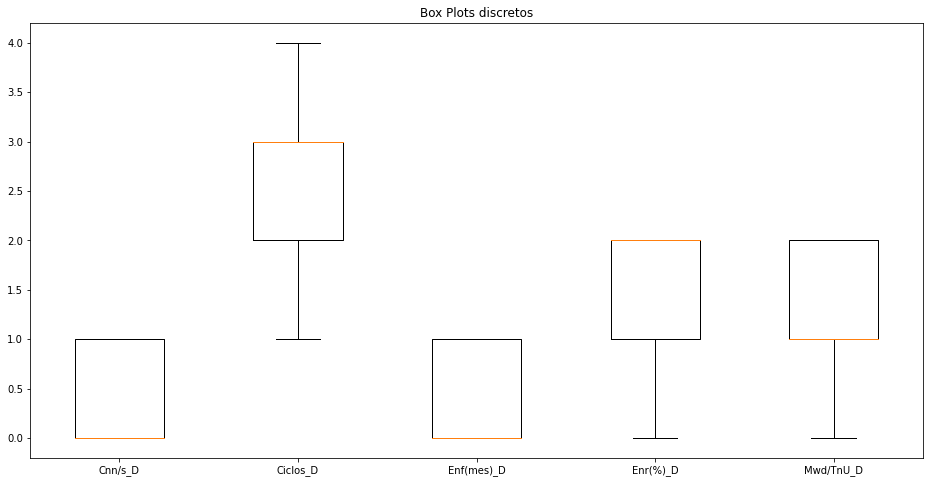

In [8]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plots normalizados')
ax1.boxplot(data.values[:,5:10], labels=data.columns.tolist()[5:10])
plt.show()

fig2, ax2 = plt.subplots(figsize=(16,8))
ax2.set_title('Box Plots discretos')
ax2.boxplot(data.values[:,10:], labels=data.columns.tolist()[10:])
plt.show()

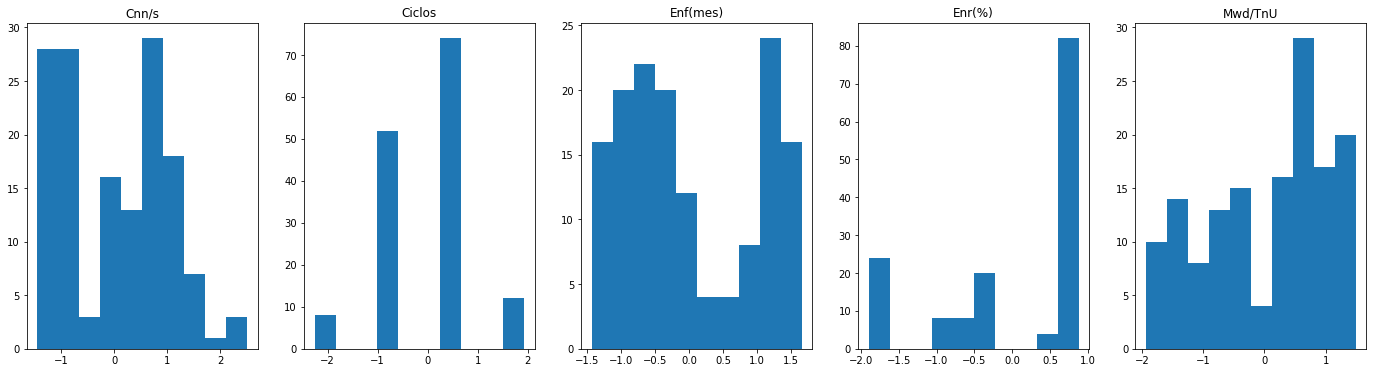

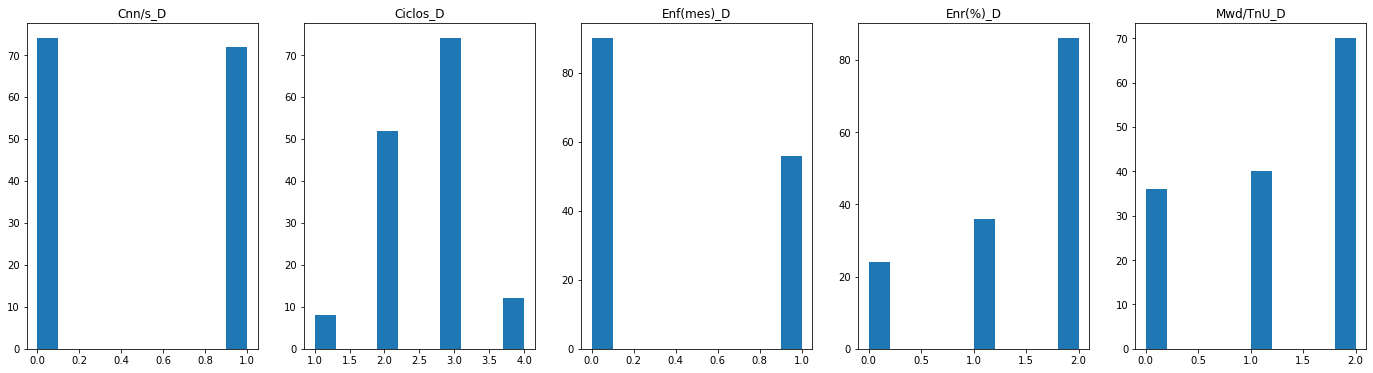

In [9]:
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))

variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax3[a].hist(data[var].values)
    ax3[a].set_title(var)
    a+1
plt.show()


fig4,ax4 = plt.subplots(1,5,figsize=(24,6))

variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax4[a].hist(data[var].values)
    ax4[a].set_title(var)
    a+1
plt.show()

### ScatterPlot de las cuentas neutrónicas por segundo respecto al quemado

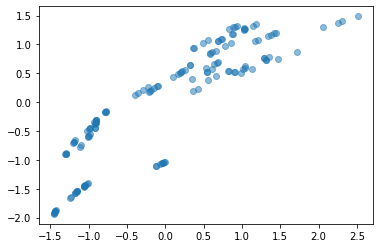

In [10]:
plt.scatter(data['Cnn/s'], data['Mwd/TnU'], alpha=0.5)
plt.show()

Se ve correlación lineal entre las cuentas neutrónicas y el quemado. Parece que hay varias tendencias lineales. ¿Se deberá a alguna de las otras variables?


### Coeficiente de correlación

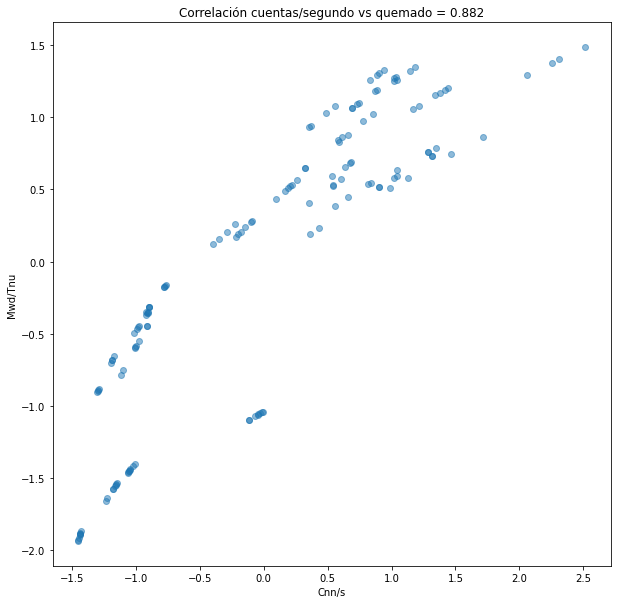

In [11]:
indep = data['Cnn/s'].values
dep = data['Mwd/TnU'].values

corrcoef = np.corrcoef(indep,dep)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(indep,dep, 'o', alpha=0.5)
ax.set_title('Correlación cuentas/segundo vs quemado = {:.3f}'.format(corrcoef[0,1]))
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
plt.show()
plt.close()

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

In [12]:
# Incluyo término independiente
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']

print(B)

[1.96023753e-16 8.82261146e-01]


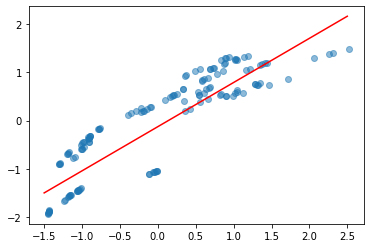

In [29]:
# La gráfica incluyendo la línea de regresión
plt.scatter(data['Cnn/s'], data['Mwd/TnU'], alpha=0.5)
plt.plot([-1.5, 2.5], [B[0]-1.5, B[0]+B[1]*2.5], c='red')
plt.show()

### Correlación separando por colores según las demás variables

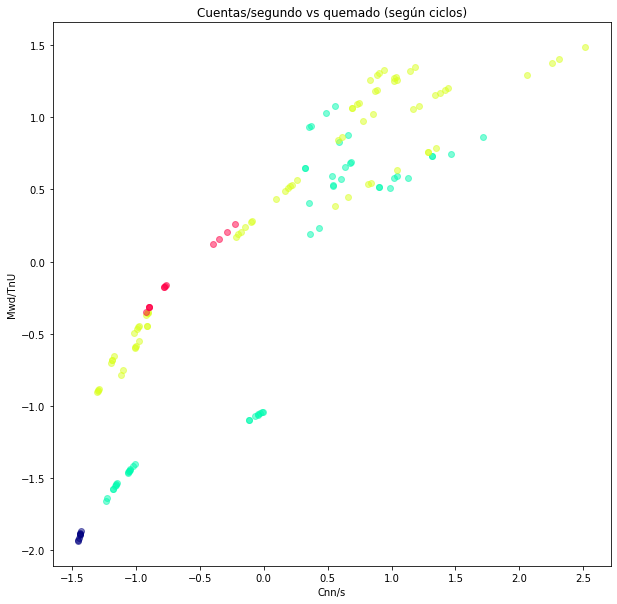

In [15]:
import matplotlib

cmap = matplotlib.cm.get_cmap('gist_ncar')

fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(data['Ciclos_D'].values))

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Ciclos_D']==i+1].values
    dep = data['Mwd/TnU'].loc[data['Ciclos_D']==i+1].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según ciclos)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
plt.close()

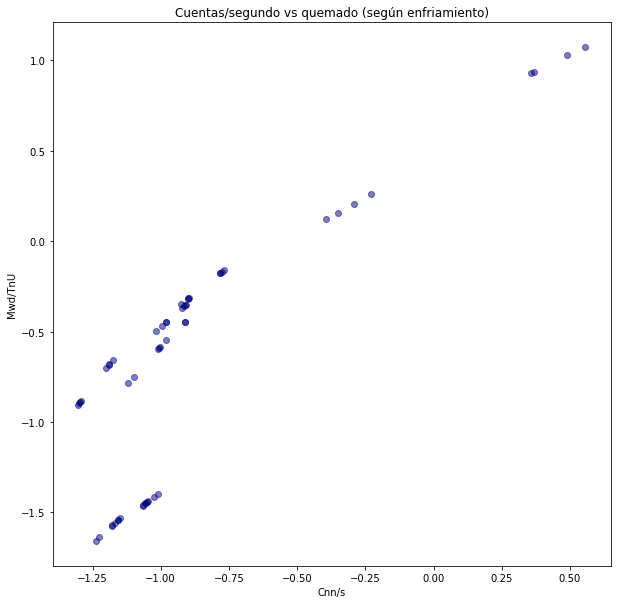

In [16]:
fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(data['Enf(mes)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enf(mes)_D']==i+1].values
    dep = data['Mwd/TnU'].loc[data['Enf(mes)_D']==i+1].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según enfriamiento)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
plt.close()

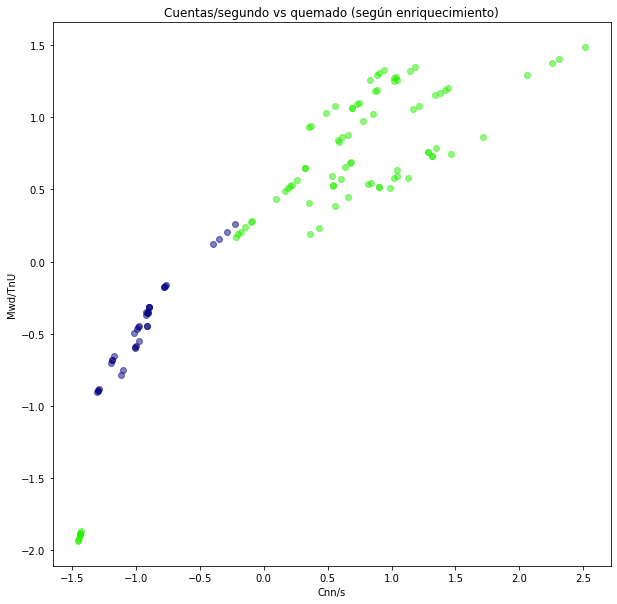

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
colores = int(np.amax(data['Enr(%)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enr(%)_D']==i+1].values
    dep = data['Mwd/TnU'].loc[data['Enr(%)_D']==i+1].values
    ax.plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax.set_title('Cuentas/segundo vs quemado (según enriquecimiento)')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/TnU')
plt.show()
plt.close()

### ¿¿¿POR QUÉ SALEN PUNTOS EN LUGARES DIFERENTES???

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [21]:
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s'], data['Ciclos'], data['Enf(mes)'], data['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']

print(B)

[4.34548231e-16 8.66154023e-01 1.01144357e-01 4.73581020e-01
 5.25804877e-01]


Ahora se supone entonces que: $Mwd/Tnu = B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

### ¿?¿? LA RELACIÓN PODRÍA SER LOGARÍTMICA EN LUGAR DE LINEAL ¿?¿?

In [27]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(data)
for train_index, test_index in loo.split(data):
        print("Entrenamiento:", train_index, "Calidación:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        print(X_train, X_test)


Entrenamiento: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145] Calidación: [0]
[[ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 

Entrenamiento: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145] Calidación: [15]
[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]


[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.21900669  0.53687549 -0.6020618   0.87125805]
 [ 1.          1.46712561 -0.86283561 -1.43290196  0.73809953]
 [ 1.          0.99203243 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.12701712 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.71731782 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.28266123  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.34669809  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.28339644  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.04026225  0.53687549 -1.26486687  0.64

[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.21900669  0.53687549 -0.6020618   0.87125805]
 [ 1.          1.46712561 -0.86283561 -1.43290196  0.73809953]
 [ 1.          0.99203243 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.12701712 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.71731782 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.28266123  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.34669809  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.28339644  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.04026225  0.53687549 -1.26486687  0.64

[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.21900669  0.53687549 -0.6020618   0.87125805]
 [ 1.          1.46712561 -0.86283561 -1.43290196  0.73809953]
 [ 1.          0.99203243 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.12701712 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.71731782 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.28266123  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.34669809  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.28339644  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.04026225  0.53687549 -1.26486687  0.64

[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.21900669  0.53687549 -0.6020618   0.87125805]
 [ 1.          1.46712561 -0.86283561 -1.43290196  0.73809953]
 [ 1.          0.99203243 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.12701712 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.71731782 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.28266123  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.34669809  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.28339644  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.04026225  0.53687549 -1.26486687  0.64

[[ 1.         -0.10387269  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.21888482  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.25895381  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.1995236   0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.14416224  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.16617021  0.53687549 -0.6020618   0.87125805]
 [ 1.          0.19322597  0.53687549 -0.6020618   0.87125805]
 [ 1.         -0.21900669  0.53687549 -0.6020618   0.87125805]
 [ 1.          1.46712561 -0.86283561 -1.43290196  0.73809953]
 [ 1.          0.99203243 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.12701712 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.71731782 -0.86283561 -1.43290196  0.73809953]
 [ 1.          1.28266123  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.34669809  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.28339644  0.53687549 -1.26486687  0.64968227]
 [ 1.          1.04026225  0.53687549 -1.26486687  0.64